In [1]:
import os
import simulation
import pynbody
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table
from data_pd.dump_features import dump_features
from simulation.sfh_in_box import binned_sfh, plot_binned_sfh
import tqdm
import astropy.units as u
from simulation.units import *
from simulation.angmom import sideon, faceon

In [2]:
SIMPATH = '/home/michele/sim/MySimulations/ng'

In [3]:
SIM = 'mb.69002'
TRAJ = 'p300_a800_r600'

In [4]:
sim_path = os.path.join(SIMPATH, "{}_{}".format(SIM, TRAJ), "out")
NTH = 2
sim = simulation.Simulation(sim_path, snap_indexes=slice(None, None, NTH))

loading simulation: /home/michele/sim/MySimulations/ng/mb.69002_p300_a800_r600/out
Found parameter file
Found compiler file
Found 563 snapshots
Taking 282 snapshots (slice(None, None, 2))
Loading cosmological parameters
Found trace file
/home/michele/Software/miniconda3/lib/python3.6/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


In [5]:
sim.peri

'300'

In [6]:
snap=sim[10]

In [7]:
sideon(snap.s)
p = pynbody.analysis.profile.Profile(snap, min=0.1, max=4, nbins=100, type='lin', ndim=3)
ps = pynbody.analysis.profile.Profile(snap.s, min=0.1, max=4, nbins=100, type='lin', ndim=3)
pg = pynbody.analysis.profile.Profile(snap.g, min=0.1, max=4, nbins=100, type='lin', ndim=3)

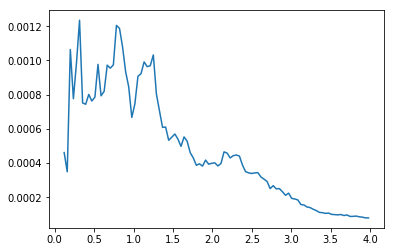

In [8]:
plt.plot(pg['rbins'], pg['density'])

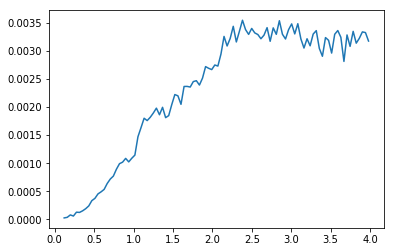

In [9]:
plt.plot(p['rbins'], p['mass'])


In [10]:
locations = np.digitize(snap.header.time, sim.dens_trace.t, right=True)
int(locations)

21968

In [11]:
sim.dens_trace.rho[int(locations)]

5.21396e-09

In [12]:
rho  = pynbody.array.SimArray(sim.dens_trace.rho[int(locations)], gadget_dens_units)
v_host = pynbody.array.SimArray(sim.dens_trace.vel[int(locations)],  gadget_vel_units)
rho, v_host

(SimArray(5.21396e-09, '1.00e+10 Msol kpc**-3'), SimArray(788.956, 'km s**-1'))

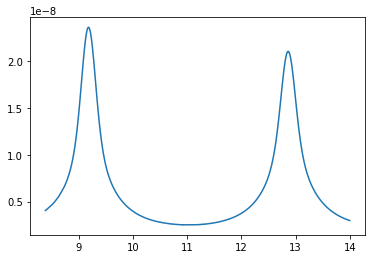

In [13]:
plt.plot(sim.dens_trace.t, sim.dens_trace.rho)

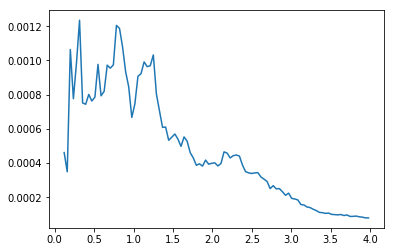

In [14]:
f, ax = plt.subplots()
# ax.plot(p['rbins'], p['mass'])
ax.plot(pg['rbins'], pg['density'])


In [15]:
G = pynbody.array.SimArray(6.674e-11, pynbody.units.Unit("N kg**-2 m**2"))
G

SimArray(6.674e-11, 'N kg**-2 m**2')

In [16]:
p_grav = G * p['mass']*pg['density']/p['rbins']
p_grav.in_units('Pa');

In [17]:
p_rps = rho * v_host**2
p_rps.in_units('Pa');

In [18]:
fun = (p_grav/p_rps).in_units(1)
fun;

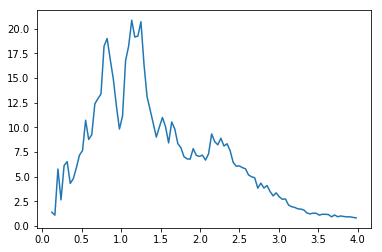

In [19]:
plt.plot(p['rbins'], fun)

In [20]:
idx = np.abs(fun.in_units(1)-1).argmin()
r_strip = p['rbins'][idx]
r_strip

3.8245

In [21]:
locations = np.digitize(sim.times.in_units(gadget_time_units), sim.dens_trace.t, right=True)
rho  = pynbody.array.SimArray(sim.dens_trace.rho[locations], gadget_dens_units)
v_host = pynbody.array.SimArray(sim.dens_trace.vel[locations],  gadget_vel_units)

In [22]:
v_host

SimArray([ 679.687,  689.884,  700.203,  710.67 ,  721.279,  732.03 ,
           742.918,  753.997,  765.326,  776.997,  788.956,  801.425,
           814.151,  827.083,  840.219,  853.509,  866.925,  880.455,
           894.087,  907.821,  921.651,  935.476,  949.528,  963.638,
           977.745,  991.823, 1005.8  , 1019.5  , 1032.73 , 1045.44 ,
          1057.5  , 1068.78 , 1079.13 , 1088.42 , 1096.58 , 1103.49 ,
          1109.09 , 1113.71 , 1117.07 , 1118.84 , 1119.04 , 1117.62 ,
          1114.6  , 1110.01 , 1103.86 , 1096.13 , 1087.05 , 1076.79 ,
          1065.5  , 1053.31 , 1040.35 , 1026.77 , 1012.71 ,  998.347,
           983.907,  969.325,  955.007,  941.145,  927.449,  913.927,
           899.893,  886.503,  873.525,  860.712,  847.942,  834.764,
           822.376,  809.638,  796.073,  782.72 ,  769.573,  756.652,
           743.946,  731.558,  720.015,  708.696,  698.045,  687.797,
           677.785,  668.017,  658.454,  649.109,  639.93 ,  630.922,
           622.078, 

In [23]:
def compute_r_strip(snap, rho_host, v_host, alpha=2):
    # McCarty: alpha =2 from sec 2.2 of Font et al. 2008
    try:
#         sideon(snap.s)
        pynbody.analysis.halo.center(snap.s)
    except ValueError:
        return np.nan
    p = pynbody.analysis.profile.Profile(snap, min=0.5, max=10, nbins=50, type='lin', ndim=3)
    pg = pynbody.analysis.profile.Profile(snap.g, min=0.5, max=10, nbins=50, type='lin', ndim=3)
    p_grav = G * p['mass']*pg['density']/p['rbins']

    p_rps = rho_host * v_host**2

    fun = alpha * (p_grav/p_rps).in_units(1)
    idx = np.abs(fun.in_units(1)-1.0).argmin()
    rs = p['rbins'][idx]
    return rs

In [24]:
r_strip_list = list()
for snap, rho_host, v_host in tqdm.tqdm(zip(sim, sim.rho_host, sim.v_host)):
    rs1 = compute_r_strip(snap, rho_host*gadget_dens_units, v_host*gadget_vel_units)
#     print(rs1)
    r_strip_list.append(rs1)
r_strip = np.array(r_strip_list)

282it [01:23,  3.88it/s]


In [25]:
r_strip

array([6.295, 6.105, 5.915, 5.915, 5.725, 5.725, 5.915, 5.915, 5.915,
       5.915, 5.915, 5.725, 5.725, 5.915, 5.915, 6.105, 5.725, 5.725,
       5.535, 5.345, 5.345, 5.155, 4.965, 4.965, 4.775, 4.965, 4.775,
       4.775, 4.775, 4.965, 4.775, 4.775, 4.585, 4.395, 4.395, 3.825,
       3.825, 3.635, 3.825, 4.015, 4.205, 4.205, 4.205, 4.205, 4.585,
       4.585, 4.775, 0.785, 4.395, 4.395, 4.205, 4.395, 4.395, 4.395,
       4.395, 4.775, 4.775, 4.965, 5.155, 5.155, 5.345, 5.155, 4.965,
       4.775, 4.775, 4.965, 5.535, 5.915, 6.105, 6.105, 5.915, 5.915,
       5.915, 5.725, 5.725, 5.725, 5.725, 5.725, 5.725, 5.725, 5.725,
       5.725, 5.725, 5.725, 6.295, 6.295, 6.295, 6.105, 6.295, 6.485,
       6.485, 6.485, 6.675, 6.675, 6.675, 6.675, 6.865, 6.675, 6.865,
       6.865, 6.865, 6.675, 6.675, 6.675, 6.485, 6.675, 6.675, 6.675,
       6.675, 6.865, 6.865, 7.055, 7.055, 7.055, 7.055, 7.055, 7.055,
       6.865, 7.055, 7.055, 7.435, 7.435, 7.435, 7.625, 8.005, 8.005,
       8.195, 8.385,

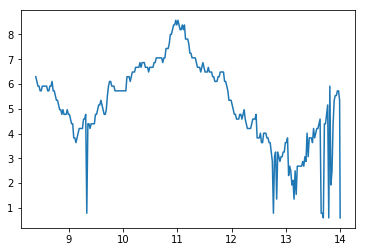

In [27]:
plt.plot(sim.times.in_units(gadget_time_units), r_strip)

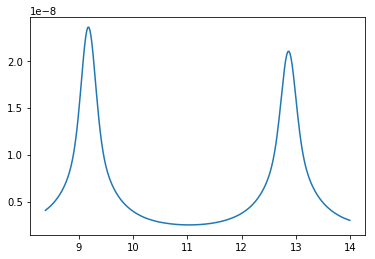

In [28]:
plt.plot(sim.times.in_units(gadget_time_units), sim.rho_host)